Gerardo Sandoval

In [ ]:
# install Neccessary Libraries
!pip install requests
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install wordcloud
!pip install seaborn
!pip install collections
!pip install re
!pip install json

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [ ]:
# Import Neccesary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import json
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

In [ ]:
# Introudce csv file
matches = pd.read_csv("matches.csv")

#Question #1: Do referees influence a away team's chances of winning a game?

When Premier League teams travel for away games, they often face challenges that can impact their performance. These include small and uncomfortable locker rooms, hostility from fans who boo throughout the match, and playing on unfamiliar fields. My investigation focuses on whether referees influence the outcome of such games to level the playing field, potentially favoring the away team. Additionally, I will analyze which referees are more likely to exhibit this tendency. With these insights, it might be possible to predict the likelihood of an away team winning based on who officiates the game.


In [ ]:
# Filter for only away wins
away_games = matches[matches['venue'] == 'Away']
away_wins = away_games[away_games['result'] == 'W']

# Count away wins based on referee and referee frequency
referee_counts = away_wins['referee'].value_counts()
total_games = matches.groupby('referee')['result'].count()

# Create into percentage rounded 2 decimal points
away_win_percentage = (referee_counts / total_games) * 100
away_win_percentage = away_win_percentage.fillna(0).round(2)

# Print the percentage of away wins for each referee
print(away_win_percentage)

referee
Andre Marriner       22.22
Andy Madley          14.75
Anthony Taylor       17.00
Chris Kavanagh       21.43
Craig Pawson         14.44
Darren England       18.00
David Coote          21.25
Graham Scott         20.83
Jarred Gillett        7.14
John Brooks          33.33
Jonathan Moss        15.38
Kevin Friend         24.05
Lee Mason            13.64
Martin Atkinson      17.71
Michael Oliver       22.22
Michael Salisbury    25.00
Mike Dean            18.39
Paul Tierney         16.47
Peter Bankes         18.52
Robert Jones         17.50
Simon Hooper         14.00
Stuart Attwell       15.38
Tony Harrington      25.00
dtype: float64


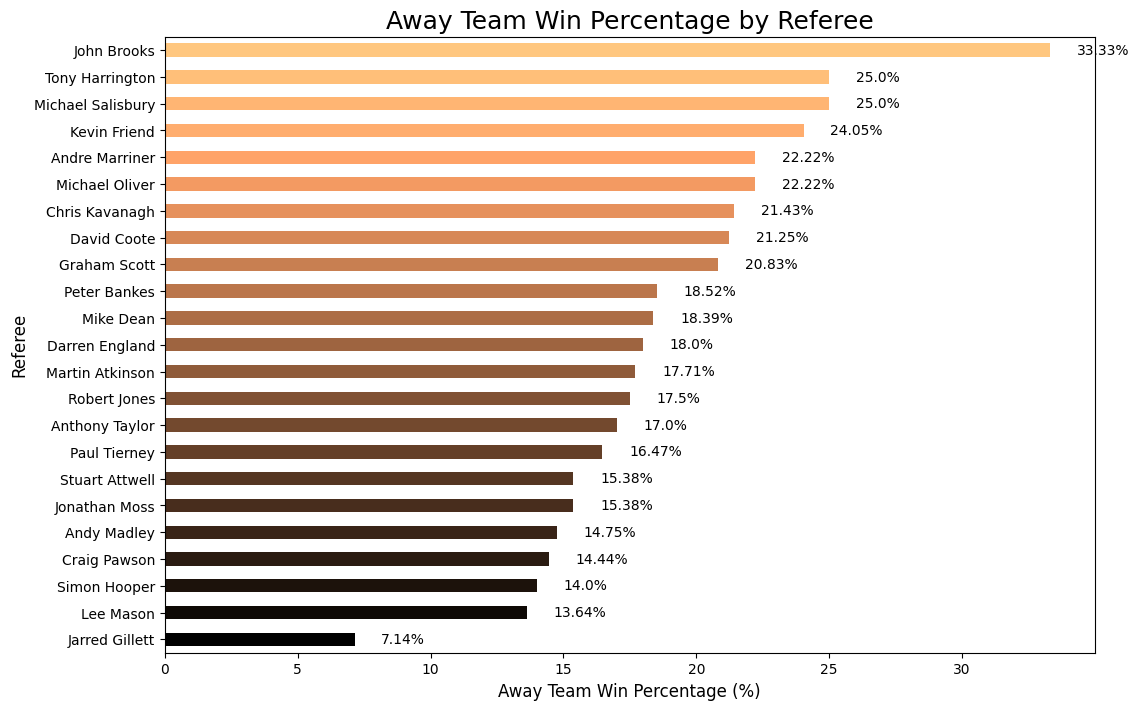

In [ ]:
#Color and Size
colors = plt.cm.copper(np.linspace(0, 1, len(away_win_percentage)))
plt.figure(figsize=(12, 8))
away_win_percentage.sort_values().plot(kind='barh', color=colors)

#Label Graph
plt.title('Away Team Win Percentage by Referee',fontsize=18)
plt.xlabel('Away Team Win Percentage (%)',fontsize=12)
plt.ylabel('Referee',fontsize=12)

#Add Percentages
for i, v in enumerate(away_win_percentage.sort_values()):
    plt.text(v + 1, i, f'{v}%', va='center', fontsize=10, color='black')
plt.show()

#Question #2: Which formation gives the opposing team the best chance to win?

Formations in soccer play a crucial role in determining a team's style and level of aggression during a game. My goal is to identify which formations are the easiest to beat. By answering this question, we can better predict a team's chances of winning based on their chosen formation.










In [ ]:
# Filter to only losses
matches_l = matches[matches['result'] == 'L']

# Extract formation based on total games and total losses
formation_total_counts = matches['formation'].value_counts()
formation_loss_counts = matches_l['formation'].value_counts()

#Create dataframe
formation_analysis = pd.DataFrame({
    'Total Games': formation_total_counts,
    'Losses': formation_loss_counts
}).fillna(0)
formation_analysis.reset_index(inplace=True)
formation_analysis.rename(columns={'index': 'Formation'}, inplace=True)

#Create loss fraction and remove
formation_analysis['Loss Fraction'] = formation_analysis['Losses'] / formation_analysis['Total Games']

#Filtering to minimum 30 games plated with formation
formation_analysis_filtered = formation_analysis[formation_analysis['Total Games'] >= 30]

#Sorting
formation_analysis_filtered = formation_analysis_filtered.sort_values(by='Total Games', ascending=False)

print(formation_analysis_filtered)


   formation  Total Games  Losses  Loss Fraction
7    4-2-3-1          344   110.0       0.319767
10     4-3-3          246    84.0       0.341463
1      3-4-3          209    77.0       0.368421
13     4-4-2          206    90.0       0.436893
4      3-5-2          138    72.0       0.521739
5    4-1-4-1           78    36.0       0.461538
0    3-4-1-2           50    21.0       0.420000
12   4-4-1-1           46    28.0       0.608696
14    4-4-2◆           33    14.0       0.424242


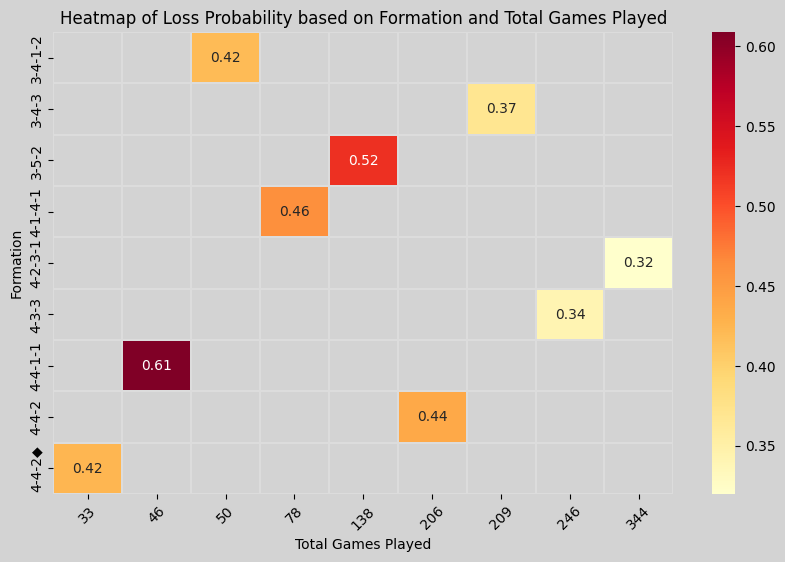

In [ ]:
# Color and Size
heatmap_data = formation_analysis_filtered.pivot(index='formation', columns='Total Games', values='Loss Fraction')
plt.figure(figsize=(10, 6), facecolor='lightgrey')
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', linewidths=0.003, fmt='.2f', linecolor='gainsboro')

#Labels and ticks
plt.title('Heatmap of Loss Probability based on Formation and Total Games Played', color='black')
plt.xlabel('Total Games Played', color='black')
plt.ylabel('Formation', color='black')
plt.xticks(rotation=45, color='black')
plt.yticks(color='black')

# Background and bar
plt.gca().set_facecolor('lightgrey')
colorbar = plt.gca().collections[0].colorbar
colorbar.ax.tick_params(labelcolor='black')

plt.show()


#Question #3: Which players can we be seen as potentional influencers after week 1 and mid-season week?


I researched the top four teams projected to win the championship this season: Manchester City, Liverpool, Chelsea, and Manchester United.
To dig deeper, I’ll use an API to extract game commentary from each team’s first two matches and two mid-season matches. The commentary will be filtered to include only goal- and assist-related comments. Based on this, I’ll create a word cloud to identify the most frequently mentioned players. This analysis will highlight the most influential players, helping refine our prediction model by identifying key performers to watch in upcoming games.

In [ ]:
# API token
api_token = "i1cbtu0BuV6nNJZrycMGgcObUwi0HPCDzQCFx35WgQlTUNI6J4TkLWafQ2PE"
def fetch_goal_comments(fixture_id):
    """
    Fetch and return goal-related comments for a given fixture ID.
    Args:
        fixture_id (int): The fixture ID for which to fetch comments.
    Returns:
        list: A list of goal-related comments.
    """
    url = f"https://api.sportmonks.com/v3/football/commentaries/fixtures/{fixture_id}"
    params = {"api_token": api_token}
    # Make API request
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()

        # Extract only goal-related comments
        if isinstance(data.get("data"), list):
            commentaries = data["data"]
            goal_comments = [
                entry["comment"]
                for entry in commentaries
                if entry.get("is_goal", False)
            ]
            return goal_comments
    return []
# Extract all game IDs
teams_fixtures = {
    "Manchester City": [18138611, 18138619, 18138803, 18138812],
    "Liverpool": [18138610, 18138618, 18138808, 18138825],
    "Chelsea": [18138608, 18138620, 18138809, 18138822],
    "Manchester United": [18138605, 18138613, 18138804, 18138814]
}
# Print all goal related comments
for team, fixtures in teams_fixtures.items():
    print(f"Goal-Related Comments for {team}:")
    for fixture_id in fixtures:
        goal_comments = fetch_goal_comments(fixture_id)
        if goal_comments:
            print(f"Fixture {fixture_id}:")
            for i, comment in enumerate(goal_comments, start=1):
                print(f"  {i}: {comment}")
    print()

Goal-Related Comments for Manchester City:

Goal-Related Comments for Liverpool:

Goal-Related Comments for Chelsea:

Goal-Related Comments for Manchester United:



In [ ]:
# Put all goal related comments into file
goal_comments = """
Goal-Related Comments for Fixture 18138608:
1: Goal!  Manchester United 5, Leeds United 1. Fred.  - Manchester United -  shot with left foot from the centre of the box to the centre of the goal. Assist -  Paul.Pogba.
2: Goal!  Manchester United 3, Leeds United 1. Bruno.Fernandes  - Manchester United -  shot with left foot from the right side of the box to the centre of the goal. Assist -  Paul.Pogba with a through ball.
4: Goal!  Manchester United 2, Leeds United 1. Mason.Greenwood  - Manchester United -  shot with left foot from a diffucult position on the left to the right corner. Assist -  Paul.Pogba   following a fast break.
5: Goal!  Manchester United 4, Leeds United 1. Bruno.Fernandes  - Manchester United -  shot with right foot from the right side of the box to the high centre of the goal. Assist -  Victor.Lindelöf with a through ball.
6: Goal!  Manchester United 1, Leeds United 0. Bruno.Fernandes  - Manchester United -  shot with left foot from the centre of the box to the centre of the goal. Assist -  Paul.Pogba with a through ball.
Goal-Related Comments for Fixture 18138620:
1: Goal!  Southampton 1, Manchester United 1. Mason.Greenwood  - Manchester United -  shot with left foot from the centre of the box to the centre of the goal. Assist -  Paul.Pogba.
Goal-Related Comments for Fixture 18138809:
2: Goal!  Manchester United 1, Burnley 0. Scott.Mctominay  - Manchester United -  shot with right foot from the centre of the box to the right corner. Assist -  Cristiano.Ronaldo.
4: Goal!  Manchester United 3, Burnley 0. Cristiano.Ronaldo  - Manchester United -  shot with right foot from the centre of the box to the centre of the goal.
Goal-Related Comments for Fixture 18138822:
3: Goal!  Aston Villa 0, Manchester United 2. Bruno.Fernandes  - Manchester United -  shot with right foot from the centre of the box to the top right corner. Assist -  Fred.
4: Goal!  Aston Villa 0, Manchester United 1. Bruno.Fernandes  - Manchester United -  shot with right foot from outside the box to the left corner. Assist -  Alex.Telles   .
Goal-Related Comments for Fixture 18138605:
1: Goal!  Chelsea 3, Crystal Palace 0. Trevoh.Chalobah  - Chelsea -  shot with right foot from outside the box to the left corner. Assist -  Mateo.Kovacic.
2: Goal!  Chelsea 2, Crystal Palace 0. Christian.Pulisic  - Chelsea -  shot with left foot from the centre of the box to the high centre of the goal.
3: Goal!  Chelsea 1, Crystal Palace 0. Marcos.Alonso  - Chelsea -  from a free kick with a shot with left foot to the top right corner.
Goal-Related Comments for Fixture 18138613:
1: Goal!  Arsenal 0, Chelsea 1. Romelu.Lukaku  - Chelsea -  shot with right foot from few metres to the centre of the goal. Assist -  Reece.James.
2: Goal!  Arsenal 0, Chelsea 2. Reece.James  - Chelsea -  shot with right foot from the centre of the box to the top left corner. Assist -  Mason.Mount.
Goal-Related Comments for Fixture 18138804:
2: Goal!  Chelsea 1, Brighton and Hove Albion 0. Romelu.Lukaku  - Chelsea -  shot with the head from the right side of the six yard box to the left corner. Assist -  Mason.Mount with a cross   after corner.
Goal-Related Comments for Fixture 18138814:
1: Goal!  Chelsea 1, Liverpool 2. Mateo.Kovacic  - Chelsea -  shot with right foot from outside the box to the top right corner    .Goal confirmed following VAR Review.
2: Goal!  Chelsea 2, Liverpool 2. Christian.Pulisic  - Chelsea -  shot with left foot from the centre of the box to the top right corner. Assist -  Ngolo.Kante with a through ball.
3: Goal!  Chelsea 0, Liverpool 1. Sadio.Mane  - Liverpool -  shot with left foot from the centre of the box to the centre of the goal.
4: Goal!  Chelsea 0, Liverpool 2. Mohamed.Salah  - Liverpool -  shot with left foot from a diffucult position on the right to the right corner. Assist -  Trent.Alexander-Arnold.
Goal-Related Comments for Fixture 18138610:
1: Goal!  Norwich City 0, Liverpool 3. Mohamed.Salah  - Liverpool -  shot with left foot from the centre of the box to the high centre of the goal    after corner.
2: Goal!  Norwich City 0, Liverpool 2. Roberto.Firmino  - Liverpool -  shot with right foot from the centre of the box to the centre of the goal. Assist -  Mohamed.Salah.
3: Goal!  Norwich City 0, Liverpool 1. Diogo.Jota  - Liverpool -  shot with right foot from the centre of the box to the centre of the goal. Assist -  Mohamed.Salah.
Goal-Related Comments for Fixture 18138618:
1: Goal!  Liverpool 1, Burnley 0. Diogo.Jota  - Liverpool -  shot with the head from the centre of the box to the centre of the goal. Assist -  Konstantinos.Tsimikas with a cross.
2: Goal!  Liverpool 2, Burnley 0. Sadio.Mane  - Liverpool -  shot with right foot from the centre of the box to the right corner. Assist -  Trent.Alexander-Arnold with a through ball.Goal-Related Comments for Fixture 18138825:
1: Goal!  Liverpool 3, Brentford 0. Takumi.Minamino  - Liverpool -  shot with right foot from the centre of the box to the right corner. Assist -  Roberto.Firmino.
2: Goal!  Liverpool 2, Brentford 0. Alex.Oxlade-Chamberlain  - Liverpool -  shot with the head from the centre of the box to the right corner. Assist -  Andrew.Robertson with a cross.
3: Goal!  Liverpool 1, Brentford 0. Fabinho.  - Liverpool -  shot with the head from few metres to the right corner. Assist -  Trent.Alexander-Arnold with a cross   after corner.
Goal-Related Comments for Fixture 18138619:
1: Goal!  Manchester City 5, Norwich City 0. Riyad.Mahrez  - Manchester City -  shot with left foot from the centre of the box to the left corner. Assist -  Rúben.Dias with a through ball.
2: Goal!  Manchester City 4, Norwich City 0. Raheem.Sterling  - Manchester City -  shot with right foot from few metres to the centre of the goal. Assist -  Gabriel.Jesus.
3: Goal!  Manchester City 3, Norwich City 0. Aymeric.Laporte  - Manchester City -  shot with right foot from the centre of the box to the right corner    after corner.
4: Goal!  Manchester City 2, Norwich City 0. Jack.Grealish  - Manchester City -  shot with left foot from few metres to the centre of the goal. Assist -  Gabriel.Jesus with a cross.
Goal-Related Comments for Fixture 18138803:
1: Goal!  Brentford 0, Manchester City 1. Phil.Foden  - Manchester City -  shot with left foot from few metres to the right corner. Assist -  Kevin.Debruyne with a cross.Goal confirmed following VAR Review.
Goal-Related Comments for Fixture 18138812:
1: Goal!  Arsenal 1, Manchester City 2. Rodri.  - Manchester City -  shot with left foot from the centre of the box to the centre of the goal.
2: Goal!  Arsenal 1, Manchester City 1. Riyad.Mahrez  - Manchester City -  converts the penalty with a shot with left foot to the right corner.
"""
with open("goal_related2_comments.txt", "w") as file:
    file.write(goal_comments)
print("Goal-related comments have been written to 'goal_related2_comments.txt'.")

Goal-related comments have been written to 'goal_related2_comments.txt'.


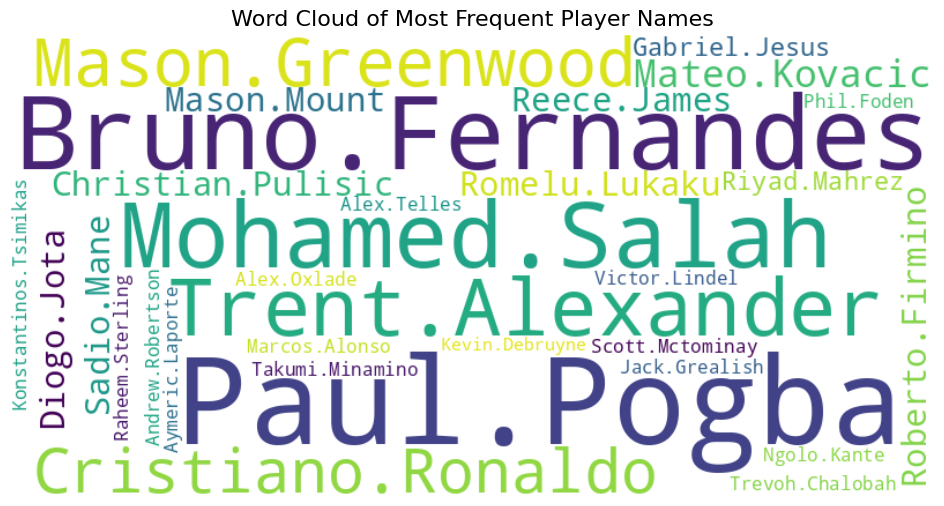

In [ ]:
# Open the file
with open("goal_related2_comments.txt", "r") as file:
    commentary = file.read()

# Use Regex to filter down only names
pattern = r"([A-Z][a-z]+\.[A-Z][a-z]+)"

# Put full names in a variable
full_names = re.findall(pattern, commentary)

# Determine frequency of each name
name_counts = Counter(full_names)

# Create new file from frequeny names
with open("full_player_names_frequency.txt", "w") as f:
    for name, count in name_counts.items():
        f.write(f"{name} {count}\n")

# Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(name_counts)

# Step 7: Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Player Names", fontsize=16)
plt.show()
